# Weight and combine the chunk velocities

## Background

We have modelled all observations of our star and saved the results to file. To retrieve the RV timeseries of the star, we still need to combine the individual best-fit velocities of all 522 chunks for each observation. One might think of a simple mean or median over the chunk velocities within each observation to achieve this - but as we have seen [in the previous chapter](./observation.ipynb) we have quite a number of 'bad' chunks, with outlier velocities and huge errors. Also, some chunks contain more spectral information than others, deliver therefore more realistic results and should be weighted higher than poorly constraint outlier chunks.

In this script, we show how to run the combination routine. For a sound mathematical description, please check out our !!!paper!!!. But basically, weights are created for each chunk not only based on their 'velocity performance' within one observation, but also based on their performance throughout the whole timeseries. I.e. if the velocity timeseries of one chunk with index $i$ shows a highly significant scatter around the mean timeseries of all chunk velocities, that chunk receives lower weight IN ALL OBSERVATIONS!

## Run the code

First of, as before, we set up the path structure and import the velocity combination routine:

In [25]:
# Automatic reloading of imports
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('/home/paul/pyodine/')  # Put in the pyodine path on your machine here!

import pyodine
import pyodine_combine_vels             # <- the velocity combination routine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Again we load an object which contains all the important parameters for the velocity combination - this is the `Timeseries_Parameters` object:

In [18]:
import utilities_song as utilities

Pars = utilities.timeseries_parameters.Timeseries_Parameters()

Next, we need to specify the pathnames for the saved model results to use. We can also define pathnames for a directory where to save analysis plots, for a log-file with diagnosis information, and a text-file where to save the RV timeseries results in a human-readable format. Also, the combined model results (including best-fit results for all observations and chunks, and the RV timeseries along with additional information), represented as a `CombinedResults` object, can be saved to a HDF5-file whose pathname we also specify below.

In [19]:
# Individual result files to use
parent_dir = '/home/paul/data_song2/data_res/sigdra_obs/'
res_files = [os.path.join(parent_dir, f, 'sigdra_res1.h5') for f in os.listdir(parent_dir)]
res_files.sort()

# The directory for analysis plots
plot_dir = '/home/paul/data_song2/data_res/sigdra_combined'

# The output name of the CombinedResults object
comb_res_out = os.path.join(plot_dir, 'sigdra_combined.h5')

# The output name of the velocity results text file
vels_out = os.path.join(plot_dir, 'sigdra.vels')

# Log files
error_file = os.path.join(plot_dir, 'error.log')
info_file  = os.path.join(plot_dir, 'info.log')

Finally, we run the velocity combination routine, which loads all the individual model results from file, computes the RV timeseries, and saves the `CombinedResults` object as well as some analysis plots and additional data as specified above. In the end the `CombinedResults` object is returned:

In [22]:
Results = pyodine_combine_vels.combine_velocity_results(
    Pars, res_files=res_files, plot_dir=plot_dir, comb_res_out=comb_res_out, 
    vels_out=vels_out, error_log=error_file, info_log=info_file)


---------------------------
Weighting and combining velocities

Star: HD185144

Barycentric velocity computation...
BVC through coordinates:
RA, DEC:       293.08995833333336, 69.661175 (deg)
PM_RA, PM_DEC: 598.07, -1738.4 (mas/yr)

Velocity weighting and combination...
---------------------------------------------------
- Pyodine chunk combination (based on iSONG code) -
---------------------------------------------------

Weighting parameters used:
	good_chunks	3	4	5	6	7	8	9	10	11	12	13	14	
	good_orders	6	7	8	9	10	11	12	13	
	sig_limit_low	4.0
	sig_limit_up	1000.0
	sig_correct	1000.0
	reweight_alpha	1.8
	reweight_beta	8.0
	reweight_sigma	2.0
	weight_correct	0.01

Nr. of obs, chunks per obs: 20, 528

Chunk-to-chunk offsets from observation mean:
Median: 6.77 +- 207.46

Chunk sigmas:
Median: 48.36 +- 35.31

RV quality factor 1 ( sqrt(1/sum(1/sig**2)) ): 1.73882 m/s
RV quality factor 2 ( sqrt(1/sum(med(wt1))) ): 1.73882 m/s

Writing results to txt file: /home/paul/data_song2/data_res/si

Great, and again some print output to explain:

- In the beginning, the weighting parameters used in the velocity combination (and supplied through the `Timeseries_Parameters` object) are printed. Also the code reports about the number of observations and chunks that it found in the results.

- Next, the (robust) mean and standard deviation (std) of the offsets of chunk timeseries from observation means are printed. Below, the mean and std of the velocity scatter within each chunk timeseries is reported ('Chunk sigmas'). The sigmas are used to weight the chunk velocities when computing the RV timeseries.

- Finally, two 'quality factors' for the velocity weighting are reported. They should always be very similar, and as they basically represent the RV precision achieved in this timeseries, you would want them to be as small as possible.

## Inspect the results

Now finally, after all this modelling, we can plot our RV timeseries:

Text(0.5, 1.0, 'HD185144: RV timeseries')

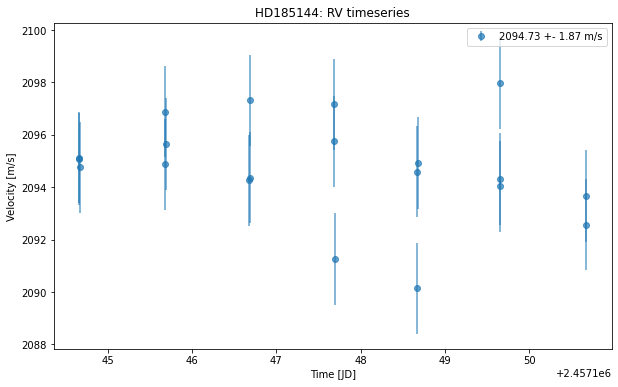

In [29]:
# The barycentric date, RV with barycentric correction, and RV uncertainty
bary_date = Results.bary_date
rv_bc     = Results.rv_bc
rv_err    = Results.rv_err

star_name = Results.info['star_name']     # the star name

# And plot
fig = plt.figure(figsize=(10,6))
plt.errorbar(bary_date, rv_bc, yerr=rv_err, fmt='o', alpha=0.7,
            label='{:.2f} +- {:.2f} m/s'.format(np.mean(rv_bc), np.std(rv_bc)))
plt.legend()
plt.xlabel('Time [JD]')
plt.ylabel('Velocity [m/s]')
plt.title('{}: RV timeseries'.format(star_name))

Text(0.5, 1.0, 'HD185144: Chromatix index variation')

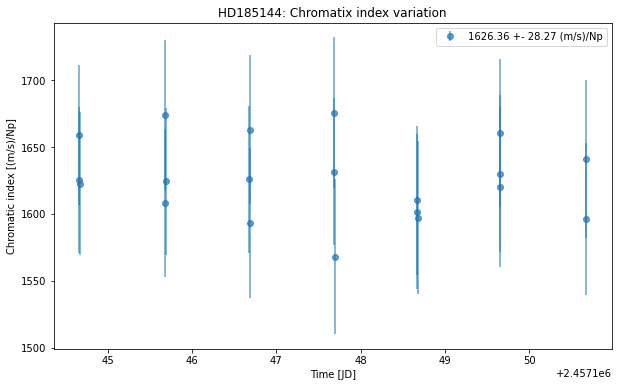

In [31]:
crx     = Results.crx
crx_err = Results.crx_err

fig = plt.figure(figsize=(10,6))
plt.errorbar(bary_date, crx, yerr=crx_err, fmt='o', alpha=0.7,
            label='{:.2f} +- {:.2f} (m/s)/Np'.format(np.mean(crx), np.std(crx)))
plt.legend()
plt.xlabel('Time [JD]')
plt.ylabel('Chromatic index [(m/s)/Np]')
plt.title('{}: Chromatix index variation'.format(star_name))

Text(0.5, 1.0, 'HD185144: Chunk velocity scatter in observations')

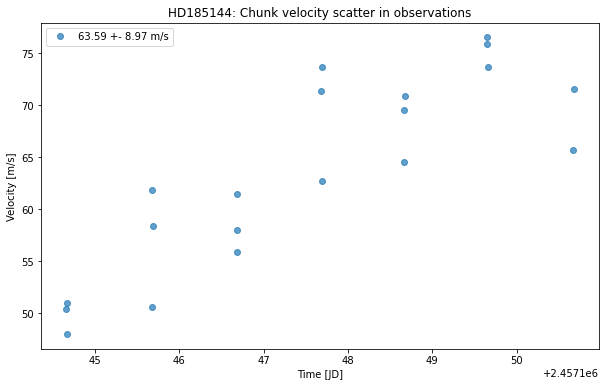

In [33]:
c2c_scatter = Results.c2c_scatter

fig = plt.figure(figsize=(10,6))
plt.plot(Results.bary_date, c2c_scatter, 'o', alpha=0.7,
        label='{:.2f} +- {:.2f} m/s'.format(np.mean(c2c_scatter), np.std(c2c_scatter)))
plt.legend()
plt.xlabel('Time [JD]')
plt.ylabel('Velocity [m/s]')
plt.title('{}: Chunk velocity scatter in observations'.format(star_name))

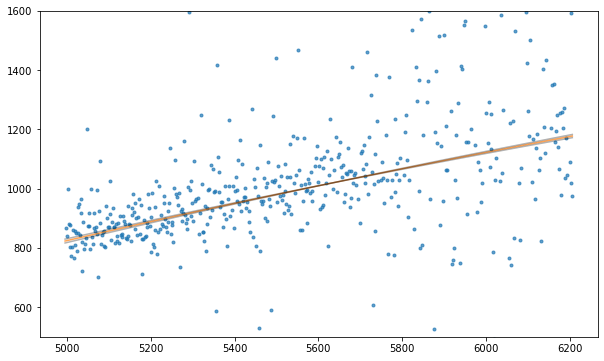

In [34]:
obs_ind = 10
velocities_fit = pyodine.timeseries.combine_vels.velocity_from_chromatic_index(
    Results.params['wave_intercept'][obs_ind], Results.rv[obs_ind], Results.RV_wave[obs_ind], Results.crx[obs_ind])
velocities_fit_lower = pyodine.timeseries.combine_vels.velocity_from_chromatic_index(
    Results.params['wave_intercept'][obs_ind], Results.rv[obs_ind]-Results.rv_err[obs_ind], 
    Results.RV_wave[obs_ind]-Results.RV_wave_err[obs_ind], Results.crx[obs_ind]-Results.crx_err[obs_ind])
velocities_fit_upper = pyodine.timeseries.combine_vels.velocity_from_chromatic_index(
    Results.params['wave_intercept'][obs_ind], Results.rv[obs_ind]+Results.rv_err[obs_ind], 
    Results.RV_wave[obs_ind]+Results.RV_wave_err[obs_ind], Results.crx[obs_ind]+Results.crx_err[obs_ind])

fig = plt.figure(figsize=(10,6))
plt.plot(Results.params['wave_intercept'][obs_ind], Results.params['velocity'][obs_ind], '.', alpha=0.7)
plt.plot(Results.params['wave_intercept'][obs_ind], velocities_fit, alpha=0.7)
plt.plot(Results.params['wave_intercept'][obs_ind], velocities_fit_lower, 'k', alpha=0.3)
plt.plot(Results.params['wave_intercept'][obs_ind], velocities_fit_upper, 'k', alpha=0.3)
plt.ylim(500., 1600.)
plt.show()
plt.close()